## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
from torchvision import transforms
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import models_mae

from pathlib import Path
from numpy.random import choice

### Define utils

In [2]:
# define the utils

mean = np.array([0.634,])
std = np.array([0.0664])

def show_image(image, title=''):
    # image is [H, W, 3]
    plt.imshow(image, cmap='viridis')
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch_16_gray'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.einsum('nhwc->nchw', img.unsqueeze(0))

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]
    
    vmin = min(im_masked[0].min(), x[0].min(), y[0].min(), im_paste[0].min())
    vmax = max(im_masked[0].max(), x[0].max(), y[0].max(), im_paste[0].max())
    plt.subplot(1, 4, 1)
    plt.imshow(x[0], cmap='viridis',  vmin = vmin, vmax=vmax)
    plt.title('original', fontsize=16)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(im_masked[0], cmap='viridis',  vmin = vmin, vmax=vmax)
    plt.title('masked', fontsize=16)
    plt.axis('off')


    plt.subplot(1, 4, 3)
    plt.imshow(y[0], cmap='viridis',  vmin = vmin, vmax=vmax)
    plt.title('reconstruction', fontsize=16)
    plt.axis('off')


    plt.subplot(1, 4, 4)
    plt.imshow(im_paste[0], cmap='viridis',  vmin = vmin, vmax=vmax)
    plt.title('reconstruction + visible', fontsize=16)
    plt.axis('off')


    plt.show()

### Load a pre-trained MAE model

In [3]:
chkpt_dir = Path('../checkpoints/checkpoint-spect.pth')
model_mae = prepare_model(chkpt_dir)
print('Model loaded.')

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


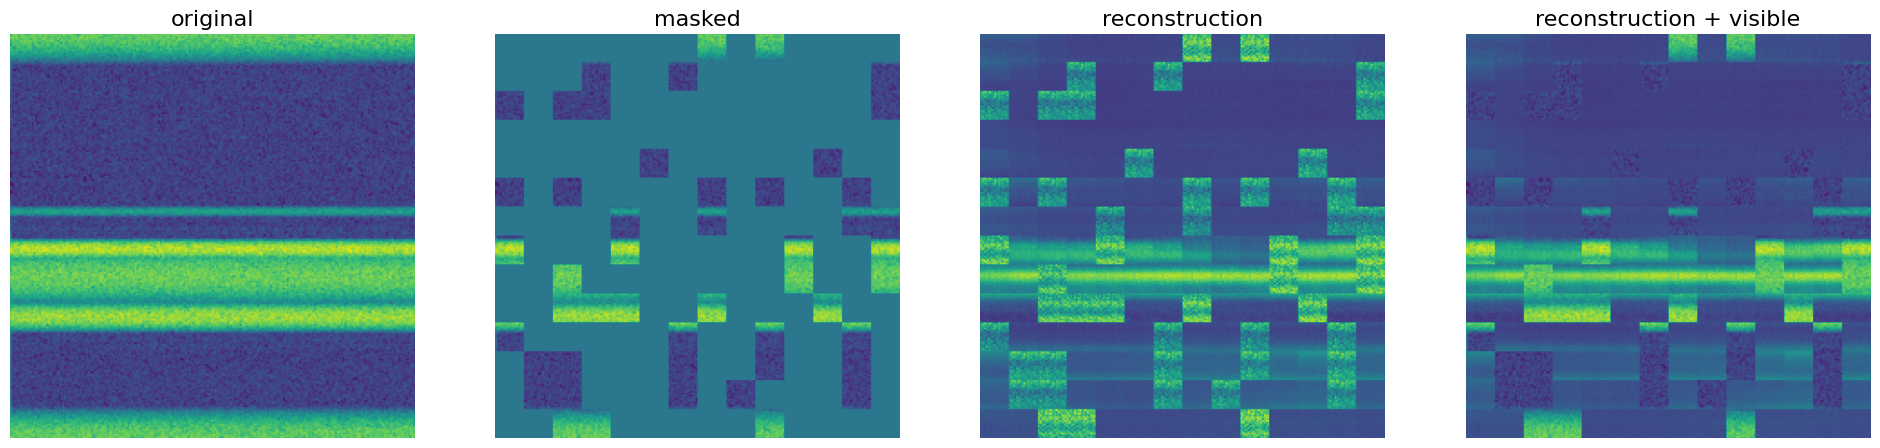

In [11]:
# samples: 75, 150
transform_train = transforms.Compose([
    transforms.functional.pil_to_tensor,
    transforms.Lambda(lambda x: 10 * torch.log10(x + 1e-12)),
    transforms.Lambda(lambda x: (x + 155.8) / (-8.41 + 155.8)),
    transforms.Resize((224, 224), antialias=True,
                      interpolation=transforms.InterpolationMode.BICUBIC),  # Resize
    transforms.Normalize(mean=[0.634], std=[0.0664])  # Normalize
])
dataset_path = Path('../../MSM/datasets/spectrogram_dataset/images')
images = os.listdir(dataset_path)
img = Image.open(os.path.join(dataset_path, choice(images)))
img = transform_train(img)
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img.reshape((224, 224, 1)), model_mae)